## Importar las librerías y bases de datos

In [ ]:
!pip install geodatasets
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive

## Visualizar las bases de datos

In [ ]:
drive.mount("/content/drive")

df_empirical_Holocene= pd.read_csv("/content/drive/MyDrive/df_empirical_Holocene.csv")
df_empirical_LGM= pd.read_csv("/content/drive/MyDrive/df_empirical_LGM.csv")

Mounted at /content/drive


In [ ]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [ ]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


In [ ]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid.


In [ ]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [ ]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

## Definir la distancia geodesica; según la fórmula presentada.

In [ ]:
def distance_geodesic(x, y):

    phi1= np.radians(x[0])
    lambda1= np.radians(x[1])
    phi2= np.radians(y[0])
    lambda2= np.radians(y[1])

    r= 6371
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distan = r * np.arccos(np.sin(phi1) * np.sin(phi2) + np.cos(phi1) * np.cos(phi2) * np.cos(lambda2 - lambda1))
    return distan

In [ ]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """

    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean

    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))

    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]

    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)

    return estimation

In [ ]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

##Estimación de vecinos cercanos con la distancia geodésica

In [ ]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geodesic"] = estimations_holocene
df_global_grid["est_lgm_geodesic"] = estimations_lgm

#Estimación con distancia euclidiana

In [ ]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol_euclidean"] = estimations_holocene
df_global_grid["est_lgm_euclidean"] = estimations_lgm

df_global_grid.head(3)

,lon,lat,est_hol_geodesic,est_lgm_geodesic,est_hol_euclidean,est_lgm_euclidean
0,-180.0,-90.0,-0.943857,0.336214,-0.736623,-0.111441
1,-177.0,-90.0,-0.943857,-0.531728,-0.736623,-0.111441
2,-174.0,-90.0,-0.611015,-0.531728,-0.736623,-0.175193


#Visualizar resultados con distancia geodésica

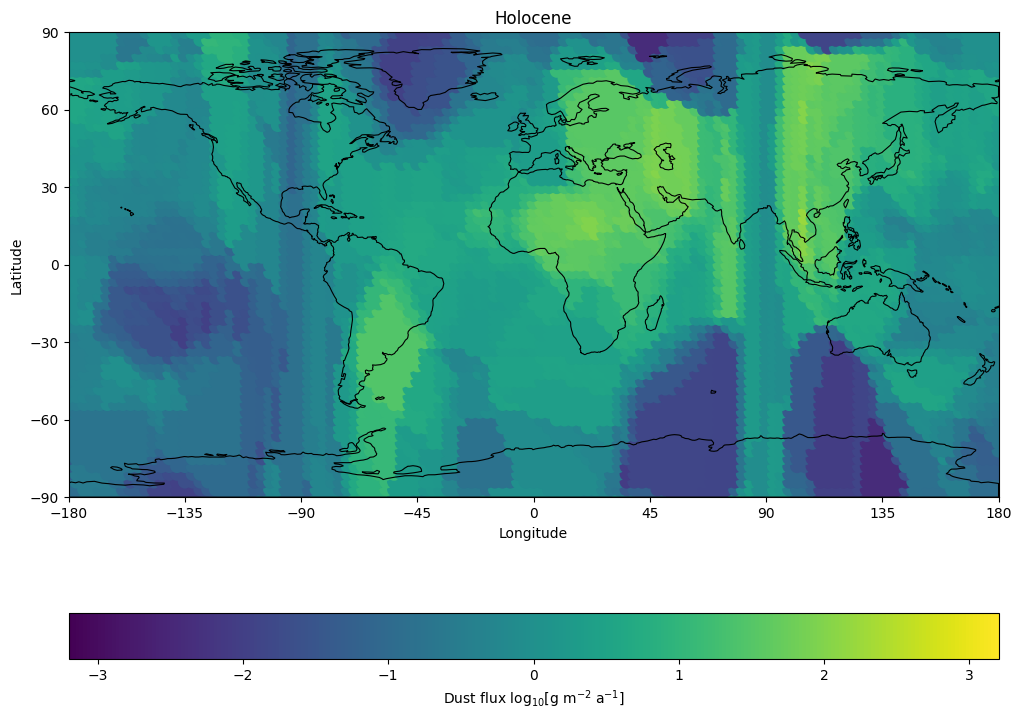

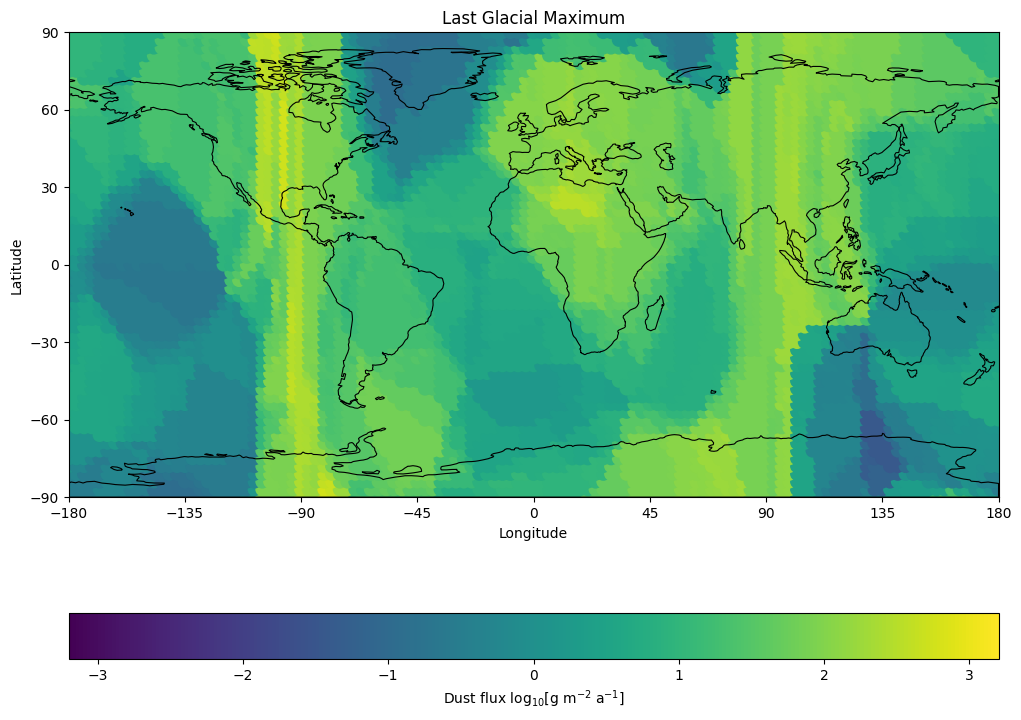

In [ ]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_geodesic')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_geodesic')

#Visualizar resultados con distancia euclidiana

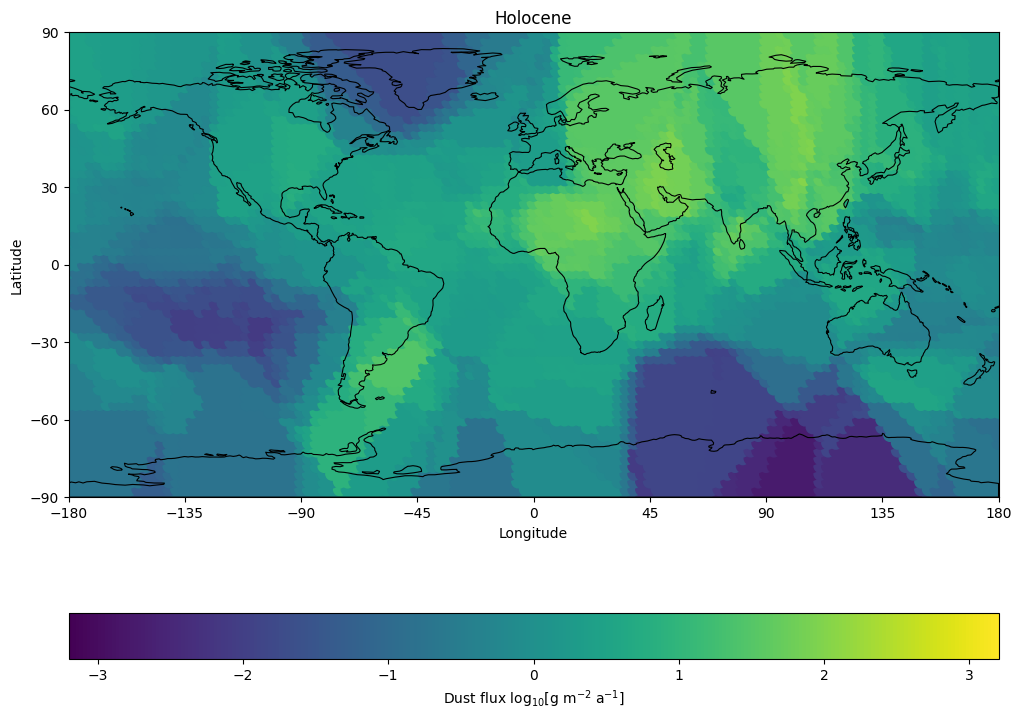

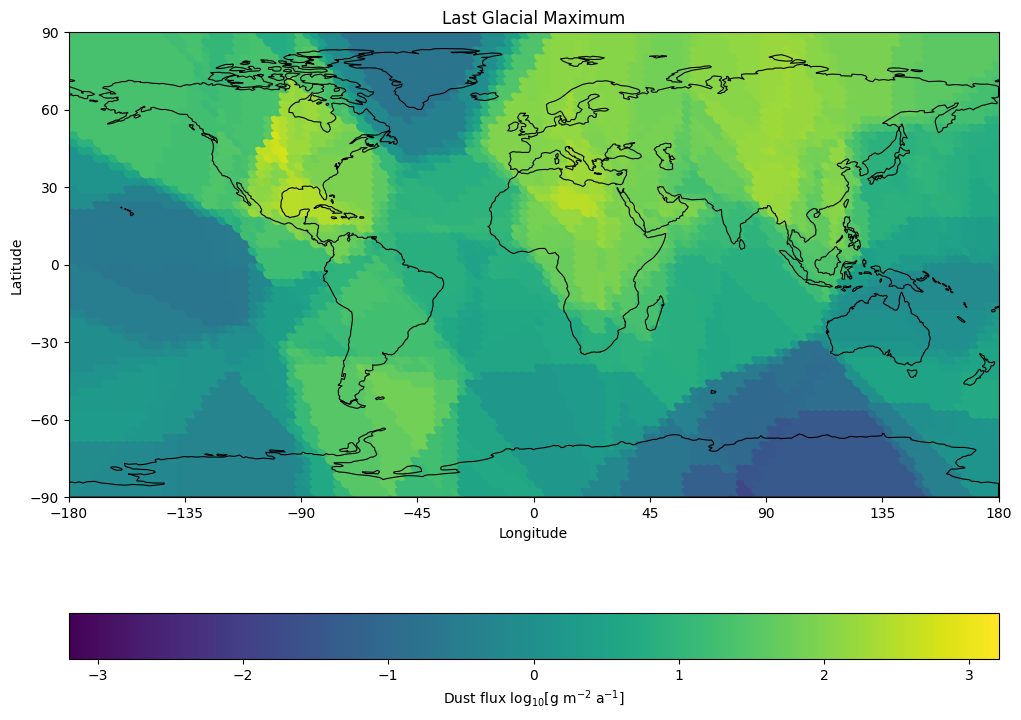

In [ ]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_euclidean')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_euclidean')

#Calcular la diferencia entre la distancia euclidiana y distancia geodésica

In [ ]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():

    # Estimacion holoceno
    euclidean_estimation_holocene= nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    geodesic_estimation_holocene= nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist="geodesic")

    # Estimacion LGM
    euclidean_estimation_LGM= nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')
    geodesic_estimation_LGM= nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = euclidean_estimation_holocene - geodesic_estimation_holocene
    estimations_lgm[index] = euclidean_estimation_LGM - geodesic_estimation_LGM

df_global_grid["est_hol_differences"] = estimations_holocene
df_global_grid["est_lgm_differences"] = estimations_lgm

df_global_grid.head(3)

,lon,lat,est_hol_geodesic,est_lgm_geodesic,est_hol_euclidean,est_lgm_euclidean,est_hol_differences,est_lgm_differences
0,-180.0,-90.0,-0.943857,0.336214,-0.736623,-0.111441,0.388625,0.595347
1,-177.0,-90.0,-0.943857,-0.531728,-0.736623,-0.111441,0.207234,-0.447655
2,-174.0,-90.0,-0.611015,-0.531728,-0.736623,-0.175193,0.207234,0.420286


## Visualizar la diferencia

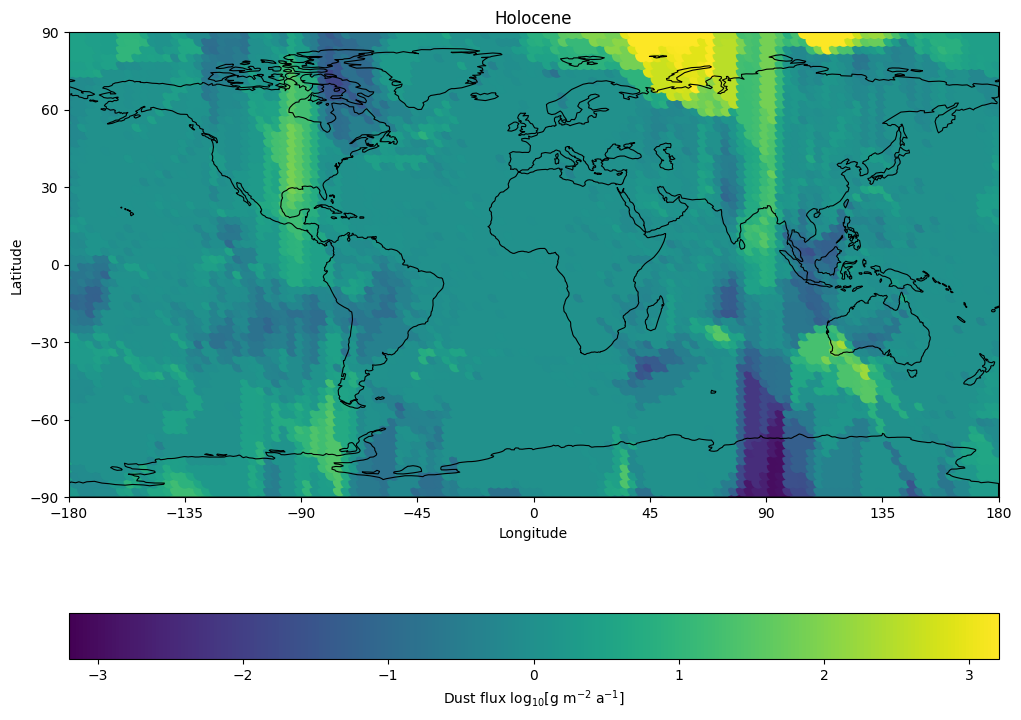

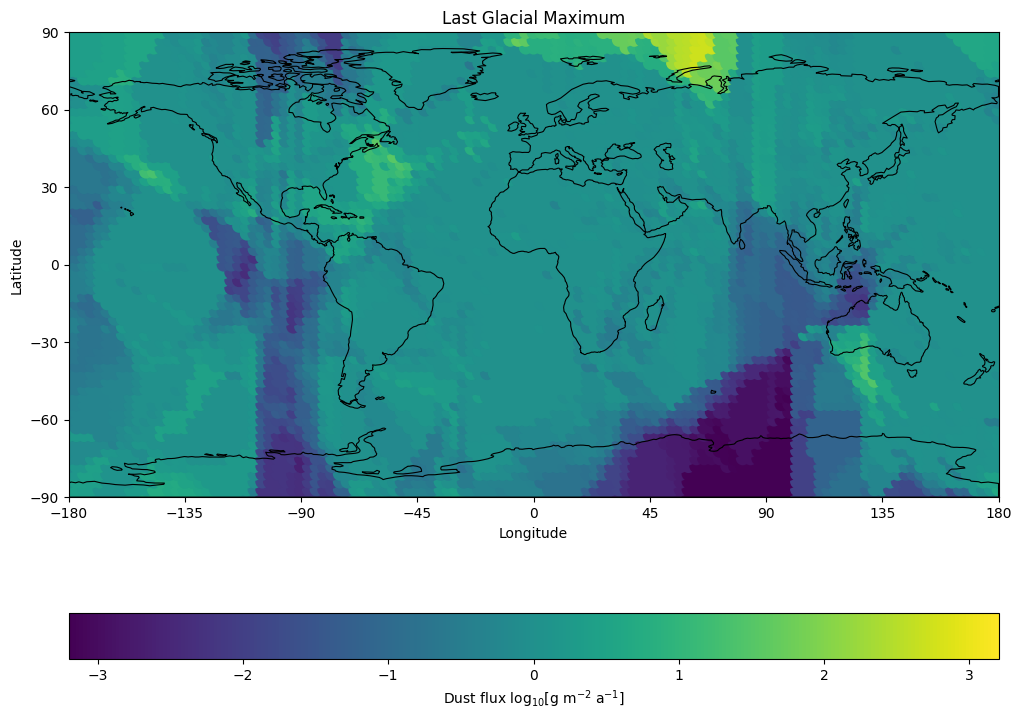

In [ ]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_differences')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_differences')

##Preguntas:

a) ¿Por que las diferencias son mas grandes en una parte que otra
parte del mundo?

Las diferencias entre los resultados de las estimaciones entre la distancia geodésica y la euclidiana se deben principalmente a la curvatura que presenta el planeta; la distancia euclidiana considera un mapa plano y no tiene en cuenta la forma esférica del planeta (que si satisface la distancia geodesica).

b) ¿Cual metodo es mas fidedigno en los polos sur y norte?

Como producto del mapa que usamos, que traslada un objeto 3D en uno 2D, los polos del planeta estan bastante distorsionados en cuanto a su tamaño real, por lo que la distancia euclidiana presenta más inconsistencias, por ello la distancia geodésica es más factible.


c) ¿Cual metodo es mas fidedigno en longitud 180◦?

Debido a que en el meridiano 180° el mapa se "corta" se puede dar lugar a resultados sesgados, por ello es mas confiable la distancia geodésica que toma en cuenta la discontinuidad.

d) ¿Cuales son las diferencias entre los resultados para el Holoceno
y el LGM?

Las diferencias entre los resultados para el holoceno y el LGM radican en la cantidad de polvo dispersado en el mapa, y con un conjunto de datos diferente, la estimacion de vecinos cercanos será diferente.


e) ¿Como elegir el numero de vecinos cercanos?

El número de vecinos cercanos a considerar dependerá del conjunto de datos que disponemos; el como estan distribuidos nos indicará que cantidad de vecinos elegir. Como en nuestra base de datos, los datos son poco densos y estan dispersos, convendría mas escoger un alto número de vecinos cercanos.

